In [40]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [49]:
from generation import FiguresDataset, id_to_cname
from process import show_img, pick, sample
id_to_cname

['Circle', 'Rhombus', 'Rectangle', 'Triangle', 'Hexagon']

In fact we can't use typical augmentations (rotate, shift, crop) on those images (despite their symmetry as bias) cause that would impact labels (bounding boxes)

In [50]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [51]:
ds = FiguresDataset(transforms=transform)

10000 images and their descriptions have been loaded successfully


We've casted our dataset to torch.float tensors scaled to $[0,1]$ and normalized (sub mean div std), and their labels - list of tuples $(shape, xmin, ymin, xmax, ymax)$

In [52]:
ds[0][0].dtype, ds[0][1]

(torch.float32,
 [(1, 16, 32, 76.10407640085654, 92.10407640085654),
  (4, 20, 190, 71.8, 241.8),
  (3, 168, 18, 240.0, 113.0)])

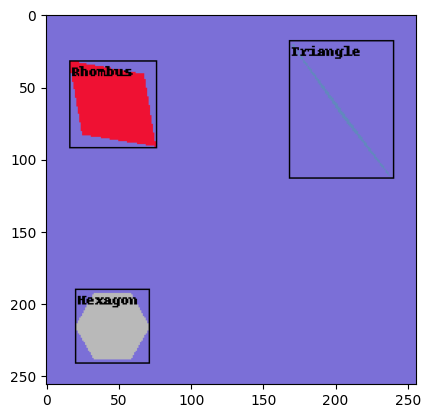

In [53]:
show_img(pick(ds[0]))

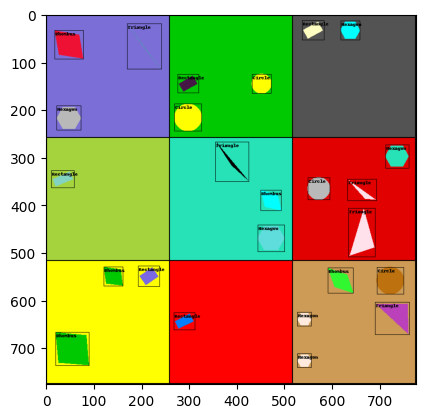

In [54]:
sample(ds)

I am going to implement YOLOv3 

YOLO is an agorithm that processes whole image in 1-pass manner using just convolutions

Our feature detector is somewhat typical, i.e. we stick to 75 convolutional layers only, so that is FCN (but with bells and whistles) and it outputs some feature map

But the classifier/regressor is 1x1 convolution over feature map, results in prediction of a a cell map (same size) ~ each cell can predict a fixed amount of bounding boxes (let it be B=3 for v3)

Then, condition of each bbox is described by $5+C$ parameters:

- x, y - center, w, h - dimensions for bounding box --> 4
- o - objectness score (confidence t) --> 1
- all class scores --> C (number of classes, we have 5 figures)


And, therefore our feature map must yield $B*(5+C)$ entries